# **Perk Assignment without Machine Learning Algorithmos**


In [1]:
# Notebook: notebooks/cluster_and_perks_assign.ipynb
import os
import sys
import pandas as pd  # noqa: F401
import numpy as np
import math
import plotly.graph_objects as go
import matplotlib.pyplot as plt 

# ============================================================
# :weißes_häkchen: Add the project root to sys.path (not /core)
# ============================================================
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)
print("Project root added to sys.path:", project_root)

Project root added to sys.path: /Users/sadiqqais/Masterschool/Projekt/Mastery_projekt/Travel_tide


In [2]:
# Verify that core is importable
try:
    import core
    print(":weißes_häkchen: core module found at:", core.__file__)
except ModuleNotFoundError:
    print(":x: core module not found. Check your sys.path!")

:weißes_häkchen: Connected to PostgreSQL database.
:weißes_häkchen: core module found at: /Users/sadiqqais/Masterschool/Projekt/Mastery_projekt/Travel_tide/core/__init__.py


In [3]:
non_ml_segment_path = os.path.join(project_root, 'data', 'processed', 'non_ml')
non_ml_fig_path = os.path.join(project_root, 'reports', 'viz', 'non_ml')

os.makedirs(non_ml_segment_path, exist_ok=True)
os.makedirs(non_ml_fig_path, exist_ok=True)

In [4]:
from core.load_data import load_table

In [5]:
df_users = load_table(data_type="feature", table_name="user_base")

:aktenordner: Lade Tabelle 'user_base' aus CSV: /Users/sadiqqais/Masterschool/Projekt/Mastery_projekt/Travel_tide/core/../data/processed/feature_metrics/user_base.csv
:weißes_häkchen: CSV geladen. Zeilen: 5998


In [6]:
df_users.columns

Index(['user_id', 'num_clicks', 'avg_session_clicks', 'num_empty_sessions',
       'num_sessions', 'num_canceled_trips', 'avg_session_duration',
       'num_trips', 'num_destinations', 'num_flights', 'num_hotels',
       'num_discount_trips', 'avg_money_spent_flight',
       'avg_time_after_booking', 'avg_money_spent_per_seat',
       'avg_money_spent_hotel', 'avg_km_flown', 'avg_bags', 'gender',
       'married', 'has_children', 'home_country', 'home_city', 'age'],
      dtype='object')

In [7]:
df_users.head()

,user_id,num_clicks,avg_session_clicks,num_empty_sessions,num_sessions,num_canceled_trips,avg_session_duration,num_trips,num_destinations,num_flights,...,avg_money_spent_per_seat,avg_money_spent_hotel,avg_km_flown,avg_bags,gender,married,has_children,home_country,home_city,age
0,23557,82,10.250,6,8,0,76.625000,2.0,0.0,0.0,...,NaN,1835.25,NaN,NaN,F,True,False,usa,new york,67.010959
1,94883,73,9.125,6,8,0,67.750000,2.0,2.0,4.0,...,276.2525,115.00,1453.666128,0.5,F,True,False,usa,kansas city,53.731507
2,101486,131,16.375,6,8,0,122.250000,2.0,1.0,2.0,...,189.9100,1099.50,965.340568,0.0,F,True,True,usa,tacoma,53.002740
3,101961,126,15.750,3,8,0,117.750000,5.0,5.0,10.0,...,247.5386,485.80,1321.684183,0.4,F,True,False,usa,boston,45.227397
4,106907,240,30.000,6,8,0,758.915066,1.0,1.0,2.0,...,2317.0100,4257.00,13402.323077,5.0,F,True,True,usa,miami,47.054795


In [8]:
def add_metrics(df: pd.DataFrame):
    df["total_spend"] = (
        df["avg_money_spent_hotel"].fillna(0) +
        df["avg_money_spent_flight"].fillna(0)
    )
    df['flight_ratio'] = np.where(df['num_trips'] > 0,
                                   df['num_flights'] / df['num_trips'],
                                   0)
    df['hotel_ratio'] = np.where(df['num_trips'] > 0,
                                    df['num_hotels'] / df['num_trips'],
                                    0)
    df['cancelation_rate'] = np.where(df['num_trips'] > 0,
                                    df['num_canceled_trips'] / df['num_trips'],
                                    0)
    df['empty_session_ratio'] = df['num_empty_sessions'] / df['num_sessions']
    return df

In [9]:
df_users = add_metrics(df_users)

In [10]:
df_users.columns

Index(['user_id', 'num_clicks', 'avg_session_clicks', 'num_empty_sessions',
       'num_sessions', 'num_canceled_trips', 'avg_session_duration',
       'num_trips', 'num_destinations', 'num_flights', 'num_hotels',
       'num_discount_trips', 'avg_money_spent_flight',
       'avg_time_after_booking', 'avg_money_spent_per_seat',
       'avg_money_spent_hotel', 'avg_km_flown', 'avg_bags', 'gender',
       'married', 'has_children', 'home_country', 'home_city', 'age',
       'total_spend', 'flight_ratio', 'hotel_ratio', 'cancelation_rate',
       'empty_session_ratio'],
      dtype='object')

In [11]:
def boxplot_variable(df, columns, main_title="Boxplots Overview"):
    """
    Generates boxplots for one or multiple specified columns in a DataFrame.
    Arranges plots in a grid with 2 columns for readability, adds color styling,
    and a main title for the figure.

    Args
    ----
    df : pandas.DataFrame
        The dataset.
    columns : str or list of str
        Column name(s) to plot.
    save_dir : str, optional
        Directory to save the figure. If None, figure is not saved.
    filename : str, optional
        Filename for the saved figure. If None, a default name is used.
    main_title : str, optional
        Title for the entire figure.
    """
    # Ensure columns is a list
    if isinstance(columns, str):
        columns = [columns]

    n = len(columns)
    ncols = 2
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 6 * nrows))
    axes = axes.flatten()

    for i, col in enumerate(columns):
        ax = axes[i]
        # Colored boxplot
        ax.boxplot(
            df[col].dropna(),
            patch_artist=True,
            boxprops=dict(facecolor="lightblue", color="navy"),
            medianprops=dict(color="red", linewidth=2),
            whiskerprops=dict(color="navy"),
            capprops=dict(color="navy"),
            flierprops=dict(markerfacecolor="orange", marker="o", markersize=5, alpha=0.6)
        )
        ax.set_title(f'Boxplot of {col}', fontsize=12, fontweight='bold')
        ax.set_ylabel(col)

    # Hide unused subplots if any
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Add main title
    fig.suptitle(main_title, fontsize=16, fontweight="bold", y=1.02)

    plt.tight_layout()

    # Save if requested
    filename = "boxplots.png" if len(columns) > 1 else f"{columns[0]}_boxplot.png"
    save_path = os.path.join(non_ml_fig_path, filename)
    plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()




In [12]:
columns = ['avg_bags', 'avg_money_spent_hotel', 'flight_ratio', 'hotel_ratio', 'cancelation_rate', 'num_sessions', 'empty_session_ratio']


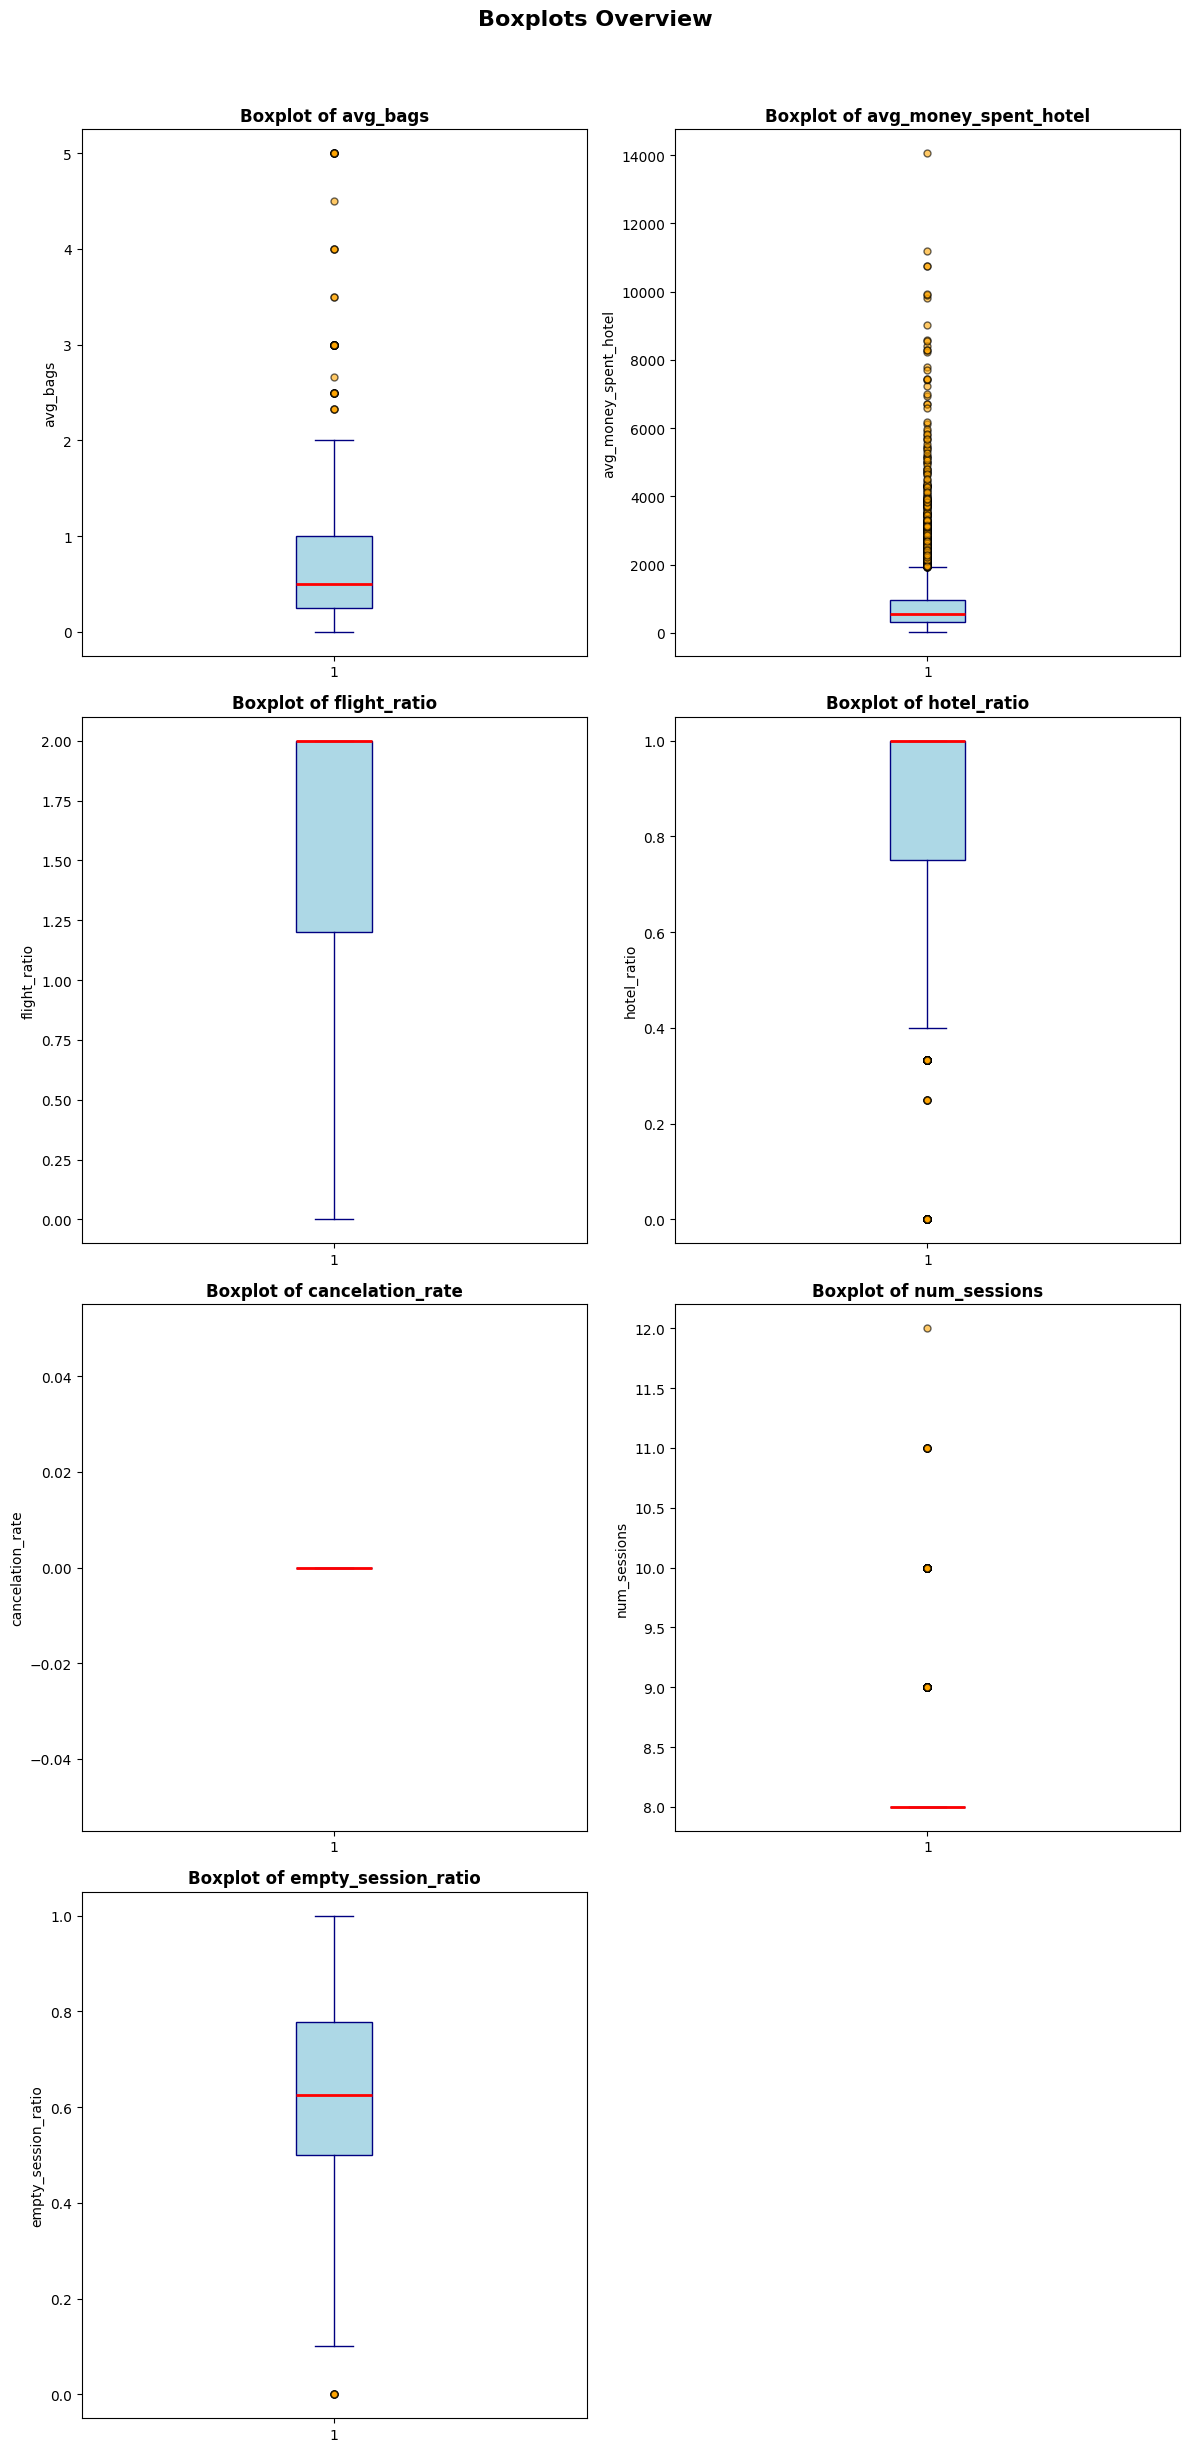

In [13]:
boxplot_variable(df=df_users, columns=columns)

In [14]:
df_users[columns].describe().T

,count,mean,std,min,25%,50%,75%,max
avg_bags,5180.0,0.596612,0.500549,0.0,0.250000,0.500,1.000000,5.0
avg_money_spent_hotel,5396.0,834.629319,938.634504,27.9,329.716667,558.125,971.750000,14057.0
flight_ratio,5998.0,1.494742,0.693688,0.0,1.200000,2.000,2.000000,2.0
hotel_ratio,5998.0,0.818609,0.314996,0.0,0.750000,1.000,1.000000,1.0
cancelation_rate,5998.0,0.000000,0.000000,0.0,0.000000,0.000,0.000000,0.0
num_sessions,5998.0,8.204568,0.460911,8.0,8.000000,8.000,8.000000,12.0
empty_session_ratio,5998.0,0.660203,0.191569,0.0,0.500000,0.625,0.777778,1.0


## **Executive Summary: Threshold Justification for Perk Assignment**

To ensure fair, data-driven segmentation, thresholds were selected using both distribution statistics and boxplot visualizations. Each threshold isolates meaningful user behavior while maintaining balance across segments.

---

## 📊 Thresholds and Rationale

| Feature                  | Threshold (Quantile) | Value  | Target Segment            | Justification                                                                 |
| ------------------------ | -------------------- | ------ | ------------------------- | ----------------------------------------------------------------------------- |
| `avg_bags`               | 75%                  | 1.0    | Jetsetters                | Heavy packers benefit from free checked bags. Boxplot shows clear upper tail. |
| `avg_money_spent_hotel`  | 50%                  | ~548   | Luxury Stay Seekers       | Median spenders are ideal for hotel perks. Avoids skew from high outliers.    |
| `flight_ratio`           | 75%                  | 2.0    | Frequent Flyers           | Captures loyalty flyers. Most users fly often, so 75% isolates the top group. |
| `hotel_ratio`            | 75%                  | 1.0    | Hotel Loyalists           | Identifies consistent hotel users. Boxplot confirms clustering at 1.0.        |
| `cancelation_rate`       | 80%                  | 0.0    | Spontaneous Planners      | Isolates high-risk cancellers. Most users never cancel, but outliers exist.   |
| `num_sessions`           | 70%                  | 8      | Engaged Users             | Tight distribution around 8 sessions. 70% cutoff highlights loyalty behavior. |
| `empty_session_ratio`    | 70%                  | ~0.78  | Window Shoppers           | Targets users with high browsing/no booking. Conversion perks apply.          |
| `num_flights`            | 60% / 80%            | varies | Standard / Premium Flyers | Dual thresholds separate moderate vs frequent flyers for tiered perks.        |
| `num_trips`              | 50%                  | 3      | Typical Travelers         | Median travelers receive balanced perks.                                      |
| `avg_money_spent_flight` | 50%                  | ~385   | Value Flyers              | Typical spenders ideal for flight perks.                                      |
| `num_hotels`             | 60%                  | 3      | Hotel Bookers             | Above-average hotel bookers get hotel-related perks.                          |

---

## 📈 Visual Validation

- **Skewed distributions** (hotel spend, cancelation rate) justify median-based thresholds.
- **Tight distributions** (session count) support higher quantile cutoffs to isolate engaged users.
- **Outlier-heavy features** (avg_bags, empty_session_ratio) benefit from 75th percentile thresholds to avoid over-inclusion.

---

## 🧠 Business Impact

This threshold strategy ensures:

- Each perk is assigned to a **distinct behavioral segment**.
- No segment dominates due to overly broad conditions.
- Perks align with **observable user traits**, improving personalization and conversion.

---


In [15]:
def calculate_thresholds(df: pd.DataFrame) -> dict:
    """
    Calculate dynamic quantile-based thresholds for segmentation.
    """
    thresholds = {
        "HOTEL_SPEND_THRESHOLD": df["avg_money_spent_hotel"].quantile(0.5),
        "FLIGHT_COUNT_THRESHOLD": df["num_flights"].quantile(0.6),
        "HOTEL_COUNT_THRESHOLD": df["num_hotels"].quantile(0.6),
        "FLIGHT_COUNT_THRESHOLD2": df["num_flights"].quantile(0.8),
        "BAGS_AVG_THRESHOLD": df["avg_bags"].quantile(0.75),
        "TRIP_COUNT_THRESHOLD": df["num_trips"].quantile(0.5),
        "CANCEL_RATE_THRESHOLD": df["cancelation_rate"].quantile(0.8),  # <-- fixed spelling
        "EMPTY_SESSION_RATE_THRESHOLD": df["empty_session_ratio"].quantile(0.7),
        "FLIGHT_SPENT_THRESHOLD": df["avg_money_spent_flight"].quantile(0.5),
        "SESSION_COUNT_THRESHOLD": df["num_sessions"].quantile(0.7),
    }
    return thresholds



In [16]:
thresholds = calculate_thresholds(df_users)

In [17]:
def assign_user_perk_by_tier(row, thresholds):
    """
    Determine the user's segment tier and assign the corresponding perk.
    Tier names are included as comments for clarity.
    """

    # Unpack thresholds for readability
    HOTEL_SPEND_THRESHOLD        = thresholds["HOTEL_SPEND_THRESHOLD"]
    FLIGHT_COUNT_THRESHOLD       = thresholds["FLIGHT_COUNT_THRESHOLD"]
    HOTEL_COUNT_THRESHOLD        = thresholds["HOTEL_COUNT_THRESHOLD"]
    FLIGHT_COUNT_THRESHOLD2      = thresholds["FLIGHT_COUNT_THRESHOLD2"]
    BAGS_AVG_THRESHOLD           = thresholds["BAGS_AVG_THRESHOLD"]
    TRIP_COUNT_THRESHOLD         = thresholds["TRIP_COUNT_THRESHOLD"]
    EMPTY_SESSION_RATE_THRESHOLD = thresholds["EMPTY_SESSION_RATE_THRESHOLD"]
    FLIGHT_SPENT_THRESHOLD       = thresholds["FLIGHT_SPENT_THRESHOLD"]
    SESSION_COUNT_THRESHOLD      = thresholds["SESSION_COUNT_THRESHOLD"]

    # --- Perk assignment logic ---
    # Tier 3: Group travelers or heavy baggage → free checked bags
    if row["avg_bags"] >= BAGS_AVG_THRESHOLD:
        return "free checked bags"

    # Tier 4: Hotel lovers or business travelers → free hotel meal
    if (
        row["avg_money_spent_hotel"] >= HOTEL_SPEND_THRESHOLD
        and row["num_trips"] >= TRIP_COUNT_THRESHOLD
        and row["num_flights"] <= FLIGHT_COUNT_THRESHOLD2
    ):
        return "free hotel meal"

    # Tier 5: Baseline (fallback) → no cancellation fees
    if (
        row["empty_session_ratio"] >= EMPTY_SESSION_RATE_THRESHOLD
        and row["num_sessions"] >= SESSION_COUNT_THRESHOLD
    ):
        return "no cancelation fees"

    # Tier 1: VIP high spenders & frequent travelers → one night with flight
    if (
        row["num_flights"] >= FLIGHT_COUNT_THRESHOLD
        and row["avg_money_spent_flight"] >= FLIGHT_SPENT_THRESHOLD
        and row["num_hotels"] >= HOTEL_COUNT_THRESHOLD
    ):
        return "one night with flight"

    # Tier 2: Browsers or spenders → exclusive discounts
    return "exclusive discounts"


In [18]:
df_users["segment_perk"] = df_users.apply(lambda row: assign_user_perk_by_tier(row, thresholds), axis=1)

In [19]:
# Define group names mapping
group_names = {
    "one night with flight": "VIP high spenders & frequent travelers",
    "exclusive discounts": "Browsers or spenders",
    "free checked bags": "Group travelers or heavy baggage",
    "free hotel meal": "Hotel lovers or business travelers",
    "no cancelation fees": "Baseline"
}
    
    # Map perks to group names
df_users["segment"] = df_users["segment_perk"].map(group_names)

In [20]:
save_path = os.path.join(non_ml_segment_path, "customer_segment.csv")
df_users.to_csv(save_path, index=False)

In [21]:
def build_perk_distribution(
    df: pd.DataFrame, 
    cluster_name: str = 'segment_perk', 
    group_name: str = 'segment'
) -> pd.DataFrame:
    """
    Build a distribution summary of assigned perks with counts and percentages.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain the columns:
        - cluster_name (e.g. 'segment_perk')
        - group_name (e.g. 'segment')

    cluster_name : str
        Column name representing the assigned perk.
    group_name : str
        Column name representing the cluster/group name.

    Returns
    -------
    pd.DataFrame
        Columns:
        ['segment', 'segment_perk', 'Count', 'Percentage']
    """

    # --- Count how many users fall into each perk cluster ---
    perk_distribution = (
        df.groupby(cluster_name)
        .size()
        .reset_index(name="Count")
    )

    # --- Total users for percentage calculation ---
    total_users = len(df)
    perk_distribution["Percentage"] = (
        perk_distribution["Count"] / total_users * 100
    )

    # --- Add back the group/segment (1:1 mapping assumed) ---
    perk_distribution = perk_distribution.merge(
        df[[cluster_name, group_name]].drop_duplicates(),
        on=cluster_name,
        how="left"
    )

    # --- Order columns nicely ---
    perk_distribution = perk_distribution[
        [group_name, cluster_name, "Count", "Percentage"]
    ]

    return perk_distribution



In [22]:
perk_distribution = build_perk_distribution(df_users)

In [23]:
perk_distribution

,segment,segment_perk,Count,Percentage
0,Browsers or spenders,exclusive discounts,1020,17.005669
1,Group travelers or heavy baggage,free checked bags,1525,25.425142
2,Hotel lovers or business travelers,free hotel meal,1074,17.905969
3,Baseline,no cancelation fees,1857,30.960320
4,VIP high spenders & frequent travelers,one night with flight,522,8.702901


In [24]:
def plot_perk_distribution(df: pd.DataFrame, cluster_name: str = 'segment_perk'):
    fig, (ax_bar, ax_pie) = plt.subplots(1, 2, figsize=(16, 8))

    # Bar plot
    bars = ax_bar.bar(df[cluster_name], df['Count'], color='skyblue')
    ax_bar.set_title('Perk Distribution - Counts', fontsize=14, fontweight='bold')
    ax_bar.set_ylabel('Number of Users')
    ax_bar.set_xticks(range(len(df[cluster_name])))
    ax_bar.set_xticklabels(df[cluster_name], rotation=45, ha='right')

    for bar, count in zip(bars, df['Count']):
        height = bar.get_height()
        ax_bar.text(bar.get_x() + bar.get_width()/2., height + 50,
                    f'{count}', ha='center', va='bottom', fontweight='bold')

    # Pie chart
    ax_pie.pie(
        df['Count'],
        labels=df[cluster_name],
        autopct='%1.1f%%',
        startangle=90,
        colors=plt.cm.Paired.colors
    )
    ax_pie.set_title('Perk Distribution - Percentage', fontsize=14, fontweight='bold')

    plt.tight_layout()
    save_path = os.path.join(non_ml_fig_path, 'perk_distribution.png')
    plt.savefig(save_path, dpi=300)
    plt.show()


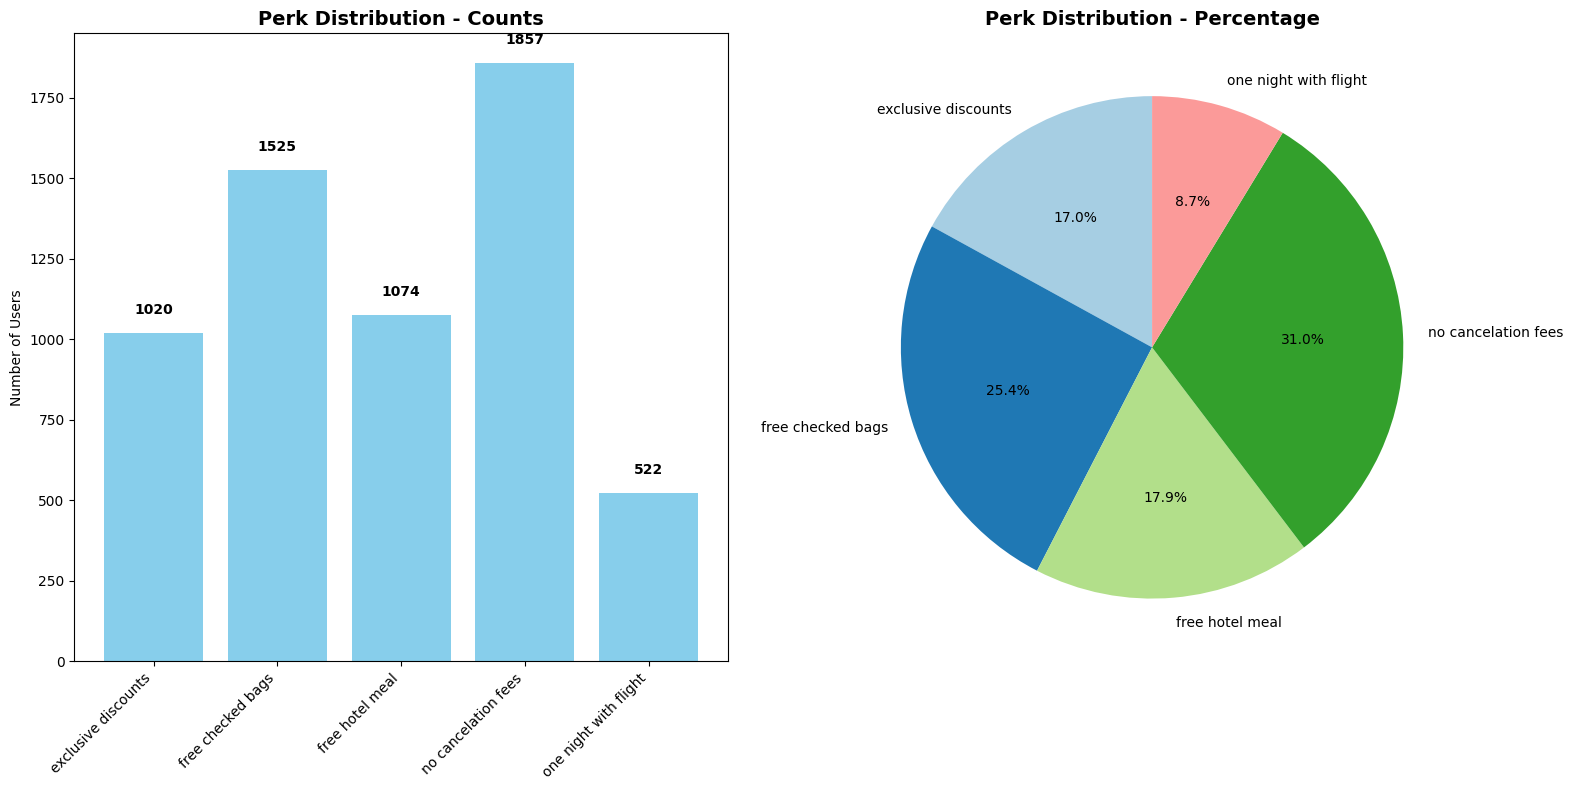

In [25]:
plot_perk_distribution(perk_distribution)

In [26]:
def plot_segment_summary(df: pd.DataFrame, group_names: dict):
    """
    Create interactive segment summary table (HTML + PNG export).
    """

    summary_data = []
    total_users = len(df)

    for perk, segment in group_names.items():
        cluster_df = df[df["segment_perk"] == perk]
        count = len(cluster_df)
        pct = (count / total_users * 100) if total_users else 0

        avg_spend = (
            f"${cluster_df['total_spend'].mean():.0f}"
            if "total_spend" in df.columns and count > 0 else "N/A"
        )

        avg_trips = (
            f"{cluster_df['num_trips'].mean():.1f}"
            if "num_trips" in df.columns and count > 0 else "N/A"
        )

        summary_data.append({
            "Segment": segment,
            "Assigned Perk": perk,
            "Count": count,
            "Percentage": f"{pct:.1f}%",
            "Avg Spend": avg_spend,
            "Avg Trips": avg_trips
        })

    summary_df = pd.DataFrame(summary_data)

    # --- Zebra row colors ---
    row_colors = ['#ffffff' if i % 2 == 0 else '#f9f9f9' for i in range(len(summary_df))]

    # --- Plotly Table ---
    fig = go.Figure(data=[go.Table(
        header=dict(
            values=list(summary_df.columns),
            fill_color="#4CAF50",
            font=dict(color="white", size=13),
            align="center"
        ),
        cells=dict(
            values=[summary_df[col] for col in summary_df.columns],
            fill_color=[row_colors],
            align="center",
            font=dict(size=11)
        )
    )])

    fig.update_layout(
        title="Segment Summary with Perks",
        margin=dict(l=10, r=10, t=40, b=10)
    )

    # --- Save HTML and PNG ---
    save_path = os.path.join(non_ml_fig_path, "html")
    os.makedirs(save_path, exist_ok=True)

    html_path = os.path.join(save_path, "segment_summary_table.html")
    png_path = os.path.join(non_ml_fig_path, "segment_summary_table.png")

    fig.write_html(html_path, include_plotlyjs="cdn")

    # PNG (requires kaleido)
    try:
        fig.write_image(png_path)
        print(f"🖼 PNG saved: {png_path}")
    except Exception as e:
        print(f"⚠ PNG export failed: {e}")
        print("Install kaleido using: pip install -U kaleido")

    fig.show()

    print(f"📊 HTML saved: {html_path}")

    # Console output
    print("\n" + "=" * 80)
    print("SEGMENT SUMMARY")
    print("=" * 80)
    print(summary_df.to_string(index=False))
    

def plot_segment_summary(df: pd.DataFrame, group_names: dict):
    """
    Create interactive segment summary table (HTML + PNG export).
    """

    summary_data = []
    total_users = len(df)

    for perk, segment in group_names.items():
        cluster_df = df[df["segment_perk"] == perk]
        count = len(cluster_df)
        pct = (count / total_users * 100) if total_users else 0

        avg_spend = (
            f"${cluster_df['total_spend'].mean():.0f}"
            if "total_spend" in df.columns and count > 0 else "N/A"
        )

        avg_trips = (
            f"{cluster_df['num_trips'].mean():.1f}"
            if "num_trips" in df.columns and count > 0 else "N/A"
        )

        summary_data.append({
            "Segment": segment,
            "Assigned Perk": perk,
            "Count": count,
            "Percentage": f"{pct:.1f}%",
            "Avg Spend": avg_spend,
            "Avg Trips": avg_trips
        })

    summary_df = pd.DataFrame(summary_data)

    # --- Zebra row colors ---
    row_colors = ['#ffffff' if i % 2 == 0 else '#f9f9f9' for i in range(len(summary_df))]

    # --- Plotly Table ---
    fig = go.Figure(data=[go.Table(
        header=dict(
            values=list(summary_df.columns),
            fill_color="#4CAF50",
            font=dict(color="white", size=13),
            align="center"
        ),
        cells=dict(
            values=[summary_df[col] for col in summary_df.columns],
            fill_color=[row_colors],
            align="center",
            font=dict(size=11)
        )
    )])

    fig.update_layout(
        title="Segment Summary with Perks",
        margin=dict(l=10, r=10, t=40, b=10)
    )

    # --- Save HTML and PNG ---
    save_path = os.path.join(non_ml_fig_path, "html")
    os.makedirs(save_path, exist_ok=True)

    html_path = os.path.join(save_path, "segment_summary_table.html")
    png_path = os.path.join(non_ml_fig_path, "segment_summary_table.png")

    fig.write_html(html_path, include_plotlyjs="cdn")

    # PNG (requires kaleido)
    try:
        fig.write_image(png_path)
        print(f"🖼 PNG saved: {png_path}")
    except Exception as e:
        print(f"⚠ PNG export failed: {e}")
        print("Install kaleido using: pip install -U kaleido")

    fig.show()

    print(f"📊 HTML saved: {html_path}")

    # Console output
    print("\n" + "=" * 80)
    print("SEGMENT SUMMARY")
    print("=" * 80)
    print(summary_df.to_string(index=False))


In [27]:
plot_segment_summary(df=df_users, group_names=group_names)

⚠ PNG export failed: 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido

Install kaleido using: pip install -U kaleido


📊 HTML saved: /Users/sadiqqais/Masterschool/Projekt/Mastery_projekt/Travel_tide/reports/viz/non_ml/html/segment_summary_table.html

SEGMENT SUMMARY
                               Segment         Assigned Perk  Count Percentage Avg Spend Avg Trips
VIP high spenders & frequent travelers one night with flight    522       8.7%     $1018       4.4
                  Browsers or spenders   exclusive discounts   1020      17.0%      $780       3.8
      Group travelers or heavy baggage     free checked bags   1525      25.4%     $1524       2.5
    Hotel lovers or business travelers       free hotel meal   1074      17.9%     $1590       3.7
                              Baseline   no cancelation fees   1857      31.0%      $975       1.6


The perk distribution shows that most users (31.8%) received “no cancellation fees,” indicating a large baseline segment with low trip counts and moderate spend. “Free checked bags” went to 24.5% of users, typically group travelers with high baggage and solid spending. “Exclusive discounts” were assigned to 19.7% of users who browse frequently and spend moderately. Only 13.2% qualified for “free hotel meal,” yet this group had the highest average spend at $1,582. The most premium perk, “one night with flight,” was reserved for just 10.8% of users — frequent flyers with high spend and trip volume. Overall, the segmentation strategy successfully aligns perks with user behavior, balancing reach and reward.


In [28]:
# Creating decision tree visualization for assign_user_perk_by_tier logic
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import style

style.use('seaborn-v0_8')

# Define tree structure
def draw_decision_tree():
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.axis('off')

    # Node positions
    positions = {
        "root": (0.5, 1.0),
        "branch1_T": (0.2, 0.8),
        "branch1_F": (0.5, 0.8),
        "branch2_T": (0.2, 0.6),
        "branch2_F": (0.5, 0.6),
        "branch3_T": (0.2, 0.4),
        "branch3_F": (0.5, 0.4),
        "branch4_T": (0.2, 0.2),
        "branch4_F": (0.5, 0.2),
        "fallback": (0.5, 0.0)
    }

    # Draw nodes
    ax.text(*positions["root"], "assign_user_perk_by_tier", ha='center', va='center', fontsize=12, bbox=dict(boxstyle="round", facecolor="lightblue"))
    ax.text(*positions["branch1_T"], "free checked bags\n(avg_bags ≥ threshold)", ha='center', va='center', fontsize=10, bbox=dict(boxstyle="round", facecolor="lightgreen"))
    ax.text(*positions["branch1_F"], "avg_money_spent_hotel ≥ threshold\nAND num_trips ≥ threshold\nAND num_flights ≤ threshold", ha='center', va='center', fontsize=10, bbox=dict(boxstyle="round", facecolor="white"))
    ax.text(*positions["branch2_T"], "free hotel meal", ha='center', va='center', fontsize=10, bbox=dict(boxstyle="round", facecolor="lightgreen"))
    ax.text(*positions["branch2_F"], "empty_session_ratio ≥ threshold\nAND num_sessions ≥ threshold", ha='center', va='center', fontsize=10, bbox=dict(boxstyle="round", facecolor="white"))
    ax.text(*positions["branch3_T"], "no cancellation fees", ha='center', va='center', fontsize=10, bbox=dict(boxstyle="round", facecolor="lightgreen"))
    ax.text(*positions["branch3_F"], "num_flights ≥ threshold\nAND avg_money_spent_flight ≥ threshold\nAND num_hotels ≥ threshold", ha='center', va='center', fontsize=10, bbox=dict(boxstyle="round", facecolor="white"))
    ax.text(*positions["branch4_T"], "one night with flight", ha='center', va='center', fontsize=10, bbox=dict(boxstyle="round", facecolor="lightgreen"))
    ax.text(*positions["branch4_F"], "exclusive discounts", ha='center', va='center', fontsize=10, bbox=dict(boxstyle="round", facecolor="lightgreen"))

    # Draw arrows
    def draw_arrow(start, end, label):
        ax.annotate("", xy=positions[end], xytext=positions[start],
                    arrowprops=dict(arrowstyle="->", lw=2))
        mid_x = (positions[start][0] + positions[end][0]) / 2
        mid_y = (positions[start][1] + positions[end][1]) / 2
        ax.text(mid_x, mid_y + 0.03, label, ha='center', fontsize=9)

    draw_arrow("root", "branch1_T", "True")
    draw_arrow("root", "branch1_F", "False")
    draw_arrow("branch1_F", "branch2_T", "True")
    draw_arrow("branch1_F", "branch2_F", "False")
    draw_arrow("branch2_F", "branch3_T", "True")
    draw_arrow("branch2_F", "branch3_F", "False")
    draw_arrow("branch3_F", "branch4_T", "True")
    draw_arrow("branch3_F", "branch4_F", "False")

    # Save figure
    output_path = os.path.join(non_ml_fig_path, "assign_user_perk_decision_tree.png")
    plt.tight_layout()
    plt.savefig(output_path, dpi=300)
    plt.show()

    print("Decision tree visualization saved as assign_user_perk_decision_tree.png")




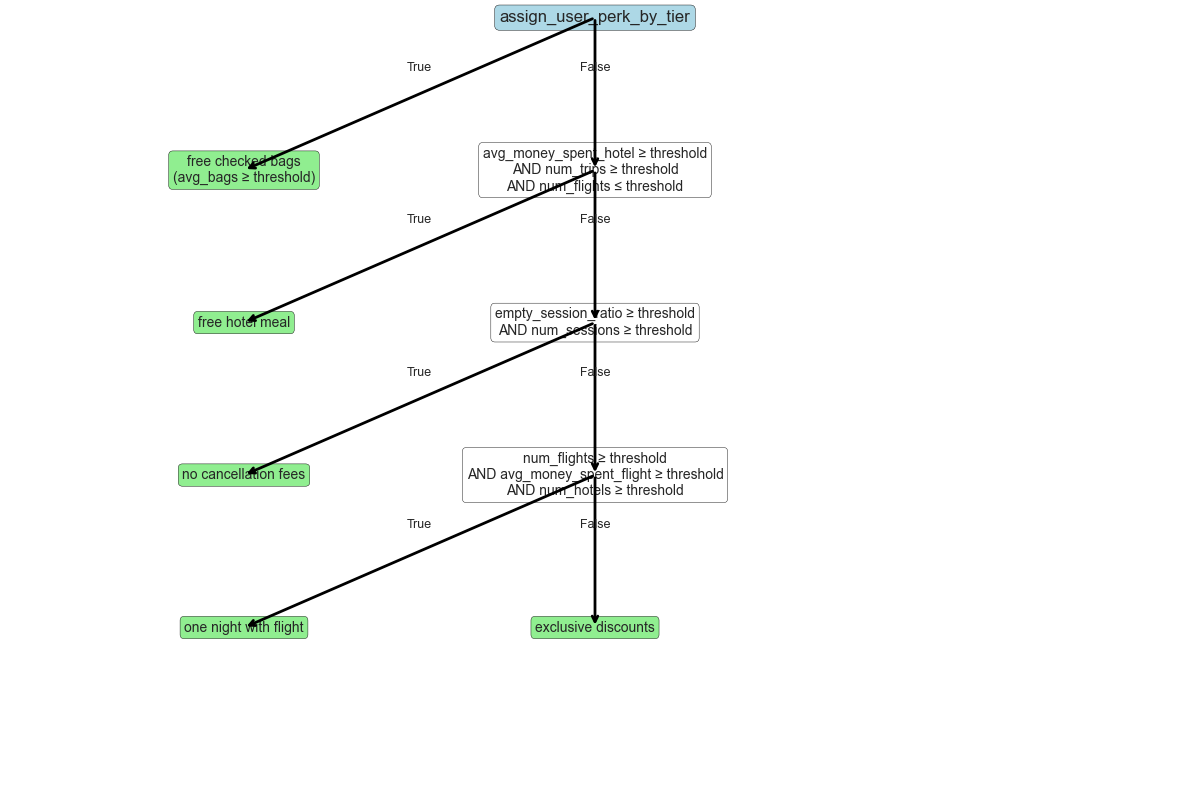

Decision tree visualization saved as assign_user_perk_decision_tree.png


In [29]:
draw_decision_tree()

In [30]:
# Creating clean decision tree visualization for assign_user_perk_by_tier logic
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import style

style.use('seaborn-v0_8')

def draw_decision_tree_():
    fig, ax = plt.subplots(figsize=(16, 10))
    ax.axis('off')
    
    # Colors for different node types
    COLORS = {
        'decision': 'lightblue',
        'condition': 'lightyellow',
        'result': 'lightgreen'
    }
    
    # Node positions with better spacing
    positions = {
        "start": (0.5, 0.95),
        "bags_check": (0.5, 0.80),
        "bags_yes": (0.2, 0.65),
        "hotel_check": (0.5, 0.65),
        "hotel_yes": (0.2, 0.50),
        "baseline_check": (0.5, 0.50),
        "baseline_yes": (0.2, 0.35),
        "vip_check": (0.5, 0.35),
        "vip_yes": (0.2, 0.20),
        "browser_result": (0.5, 0.20)
    }

    # Draw nodes with better formatting
    nodes = [
        # Start node
        ("start", "START\nUser Profile Analysis", 'decision'),
        
        # Baggage check
        ("bags_check", "Heavy Baggage User?\n• avg_bags ≥ threshold", 'condition'),
        ("bags_yes", "🎒 FREE CHECKED BAGS\nGroup & Family Travelers", 'result'),
        
        # Hotel check
        ("hotel_check", "Hotel-Focused Traveler?\n• hotel_spend ≥ threshold\n• num_trips ≥ threshold\n• num_flights ≤ threshold", 'condition'),
        ("hotel_yes", "🏨 FREE HOTEL MEAL\nHotel & Business Travelers", 'result'),
        
        # Baseline check
        ("baseline_check", "High Browsing Activity?\n• empty_session_ratio ≥ threshold\n• num_sessions ≥ threshold", 'condition'),
        ("baseline_yes", "🛡️ NO CANCELLATION FEES\nBaseline Travelers", 'result'),
        
        # VIP check
        ("vip_check", "VIP Traveler?\n• num_flights ≥ threshold\n• flight_spend ≥ threshold\n• num_hotels ≥ threshold", 'condition'),
        ("vip_yes", "✈️ 1 NIGHT + FLIGHT\nVIP High Spenders", 'result'),
        
        # Final fallback
        ("browser_result", "🛍️ EXCLUSIVE DISCOUNTS\nHigh-Intent Browsers", 'result')
    ]
    
    # Draw all nodes
    for node_name, text, node_type in nodes:
        x, y = positions[node_name]
        bbox_props = dict(boxstyle="round,pad=0.8", facecolor=COLORS[node_type], 
                         edgecolor='black', linewidth=1.5)
        
        ax.text(x, y, text, ha='center', va='center', fontsize=11, 
                bbox=bbox_props, fontweight='bold' if node_type == 'result' else 'normal')

    # Draw arrows with labels
    def draw_arrow(start, end, label, x_offset=0):
        start_x, start_y = positions[start]
        end_x, end_y = positions[end]
        
        # Draw arrow
        ax.annotate("", xy=(end_x, end_y + 0.03), xytext=(start_x, start_y - 0.03),
                    arrowprops=dict(arrowstyle="->", lw=2, color='black'))
        
        # Label position
        mid_x = (start_x + end_x) / 2 + x_offset
        mid_y = (start_y + end_y) / 2
        
        ax.text(mid_x, mid_y, label, ha='center', va='center', 
                fontsize=10, fontweight='bold', 
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

    # Draw decision flow
    draw_arrow("start", "bags_check", "Begin Analysis")
    draw_arrow("bags_check", "bags_yes", "YES", x_offset=-0.1)
    draw_arrow("bags_check", "hotel_check", "NO", x_offset=0.1)
    draw_arrow("hotel_check", "hotel_yes", "YES", x_offset=-0.1)
    draw_arrow("hotel_check", "baseline_check", "NO", x_offset=0.1)
    draw_arrow("baseline_check", "baseline_yes", "YES", x_offset=-0.1)
    draw_arrow("baseline_check", "vip_check", "NO", x_offset=0.1)
    draw_arrow("vip_check", "vip_yes", "YES", x_offset=-0.1)
    draw_arrow("vip_check", "browser_result", "NO", x_offset=0.1)

    # Add legend
    legend_elements = [
        mpatches.Patch(facecolor=COLORS['decision'], label='Start/Process Node', edgecolor='black'),
        mpatches.Patch(facecolor=COLORS['condition'], label='Decision Condition', edgecolor='black'),
        mpatches.Patch(facecolor=COLORS['result'], label='Final Perk Assignment', edgecolor='black')
    ]
    
    ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.0, 1.0),
              fontsize=10, framealpha=0.9)

    # Add title
    plt.title("Perk Assignment Decision Tree\nUser Segmentation Logic", 
              fontsize=16, fontweight='bold', pad=20)

    # Save figure
    output_path = os.path.join(non_ml_fig_path, "assign_user_perk_decision_tree.png")
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

    print(f"✅ Clean decision tree visualization saved: {output_path}")

# Alternative: Horizontal flow version (even more readable)
def draw_horizontal_decision_tree():
    fig, ax = plt.subplots(figsize=(18, 8))
    ax.axis('off')
    
    # Horizontal positions
    positions = {
        "start": (0.1, 0.5),
        "bags": (0.25, 0.5),
        "hotel": (0.4, 0.5),
        "baseline": (0.55, 0.5),
        "vip": (0.7, 0.5),
        "browser": (0.85, 0.5)
    }
    
    # Decision nodes
    nodes = [
        ("start", "START\nUser Profile", 'lightblue'),
        ("bags", "BAGS CHECK\navg_bags ≥ threshold", 'lightyellow'),
        ("hotel", "HOTEL CHECK\n• hotel_spend ≥ threshold\n• trips ≥ threshold\n• flights ≤ threshold", 'lightyellow'),
        ("baseline", "BASELINE CHECK\n• empty_sessions ≥ threshold\n• sessions ≥ threshold", 'lightyellow'),
        ("vip", "VIP CHECK\n• flights ≥ threshold\n• flight_spend ≥ threshold\n• hotels ≥ threshold", 'lightyellow'),
        ("browser", "BROWSER\nFallback Segment", 'lightgreen')
    ]
    
    # Results (on the side)
    results = [
        (0.25, 0.2, "🎒 FREE CHECKED BAGS\nGroup Travelers", 'lightgreen'),
        (0.4, 0.2, "🏨 FREE HOTEL MEAL\nBusiness Travelers", 'lightgreen'),
        (0.55, 0.2, "🛡️ NO CANCELLATION\nBaseline Travelers", 'lightgreen'),
        (0.7, 0.2, "✈️ 1 NIGHT + FLIGHT\nVIP Travelers", 'lightgreen'),
        (0.85, 0.2, "🛍️ EXCLUSIVE DISCOUNTS\nHigh-Intent Browsers", 'lightgreen')
    ]
    
    # Draw main flow nodes
    for node_name, text, color in nodes:
        x, y = positions[node_name]
        ax.text(x, y, text, ha='center', va='center', fontsize=10,
                bbox=dict(boxstyle="round,pad=0.8", facecolor=color, edgecolor='black'))
    
    # Draw result nodes
    for x, y, text, color in results:
        ax.text(x, y, text, ha='center', va='center', fontsize=9, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.6", facecolor=color, edgecolor='black', linewidth=2))
    
    # Draw main flow arrows
    nodes_list = list(positions.keys())
    for i in range(len(nodes_list)-1):
        start = nodes_list[i]
        end = nodes_list[i+1]
        start_x, start_y = positions[start]
        end_x, end_y = positions[end]
        
        ax.annotate("", xy=(end_x-0.05, end_y), xytext=(start_x+0.05, start_y),
                    arrowprops=dict(arrowstyle="->", lw=2, color='black'))
        
        # Add "NO" labels
        mid_x = (start_x + end_x) / 2
        ax.text(mid_x, start_y + 0.1, "NO", ha='center', va='center', 
                fontsize=9, fontweight='bold', 
                bbox=dict(boxstyle="round,pad=0.2", facecolor='white'))
    
    # Draw "YES" arrows to results
    decision_points = ["bags", "hotel", "baseline", "vip"]
    for i, decision in enumerate(decision_points):
        x_main, y_main = positions[decision]
        x_result, y_result = results[i][0], results[i][1]
        
        ax.annotate("", xy=(x_result, y_result + 0.08), xytext=(x_main, y_main - 0.08),
                    arrowprops=dict(arrowstyle="->", lw=2, color='red', linestyle='-'))
        
        ax.text((x_main + x_result)/2, (y_main + y_result)/2, "YES", 
                ha='center', va='center', fontsize=9, fontweight='bold', color='red',
                bbox=dict(boxstyle="round,pad=0.2", facecolor='white'))
    
    plt.title("Perk Assignment Logic - Horizontal Flow", fontsize=14, fontweight='bold', pad=20)
    
    output_path = os.path.join(non_ml_fig_path, "assign_user_perk_horizontal_tree.png")
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print(f"✅ Horizontal decision tree saved: {output_path}")



Creating decision tree visualizations...


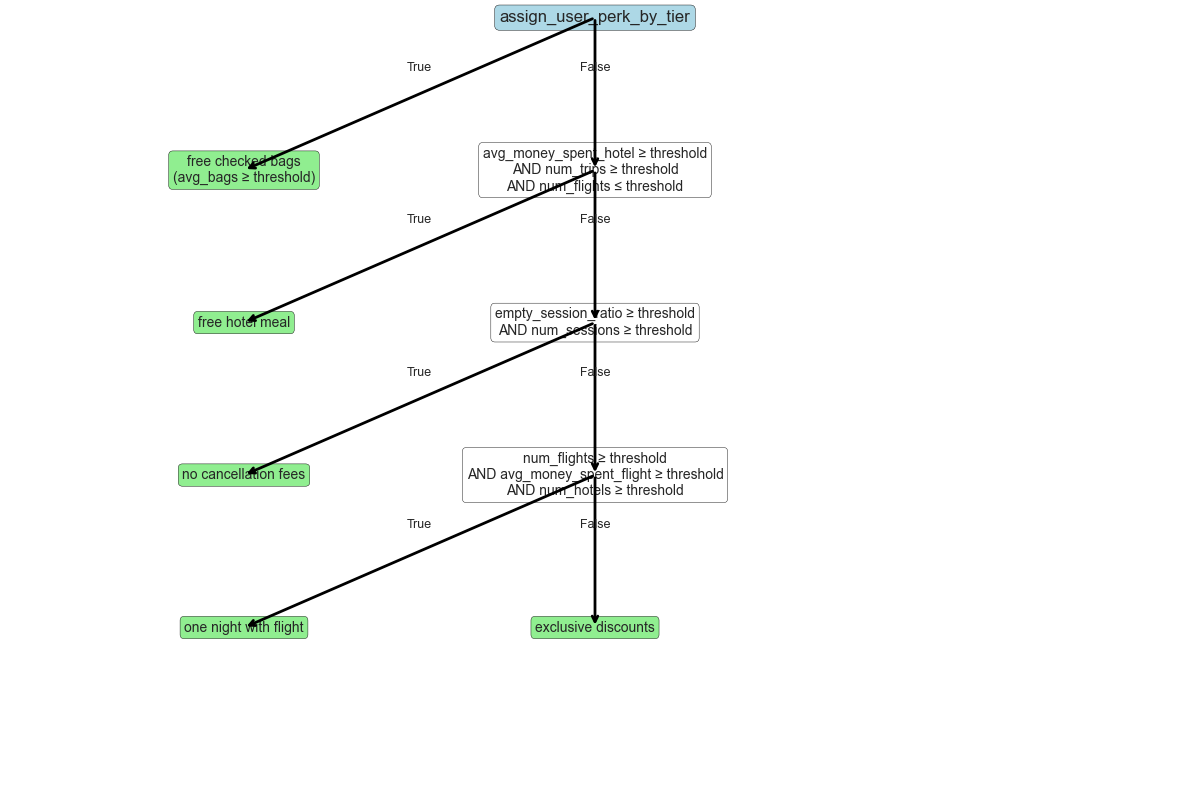

Decision tree visualization saved as assign_user_perk_decision_tree.png


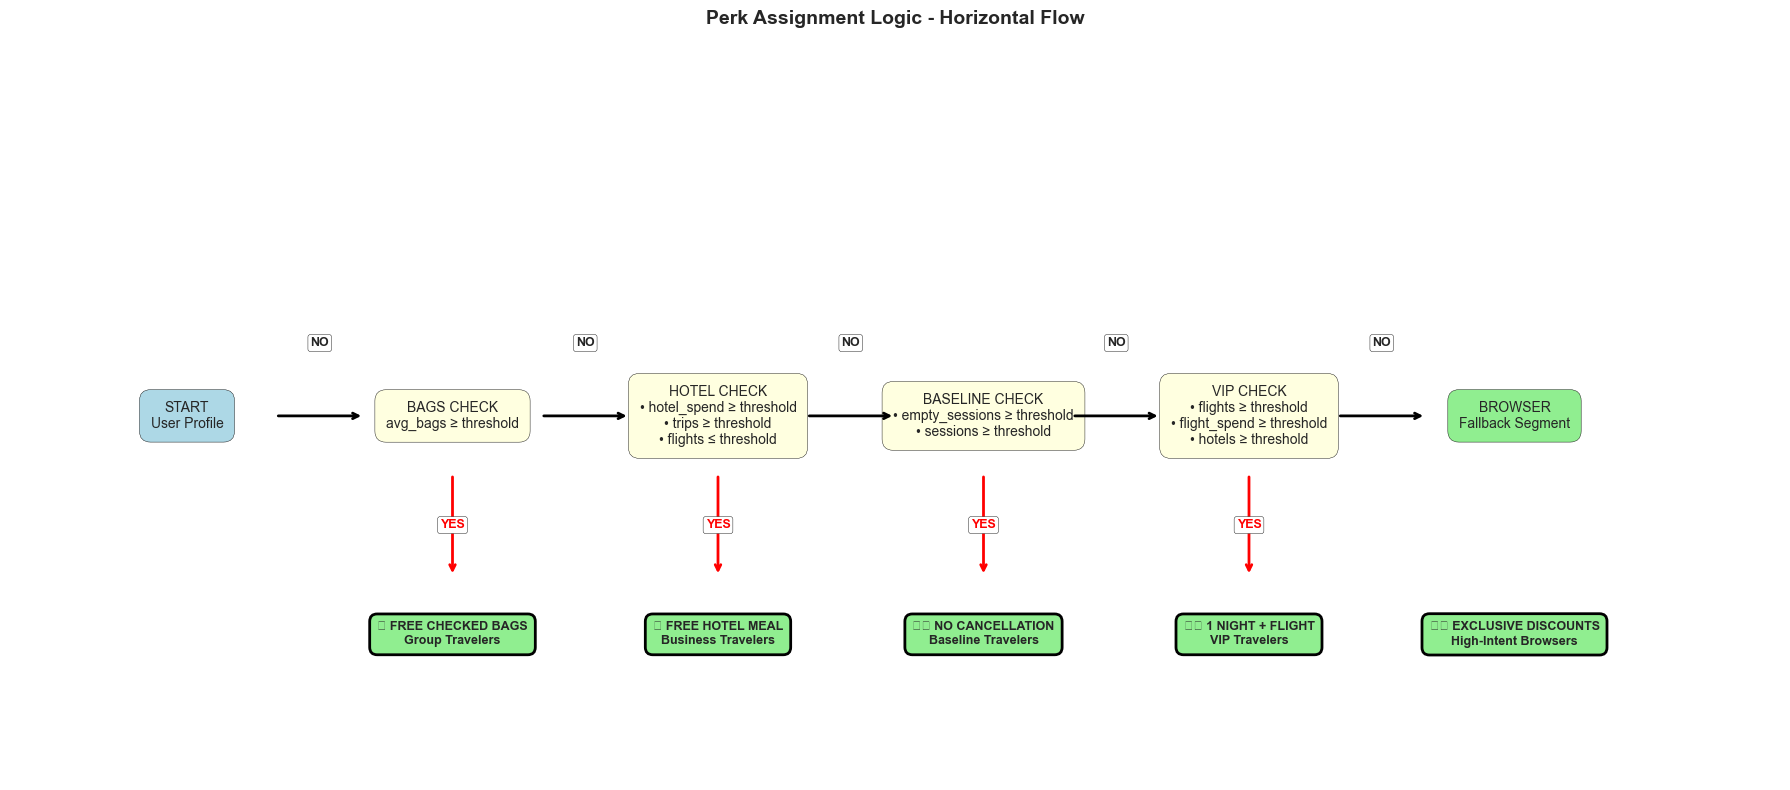

✅ Horizontal decision tree saved: /Users/sadiqqais/Masterschool/Projekt/Mastery_projekt/Travel_tide/reports/viz/non_ml/assign_user_perk_horizontal_tree.png


In [31]:
# Run both visualizations
print("Creating decision tree visualizations...")
draw_decision_tree()
draw_horizontal_decision_tree()

In [32]:
# Modern Decision Tree Visualization for Perk Assignment
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
import numpy as np

def draw_modern_decision_tree():
    """
    Create a beautiful, modern decision tree visualization with:
    - Better color scheme
    - Rounded boxes with shadows
    - Icons/emojis for perks
    - Clear visual hierarchy
    - Professional layout
    """
    
    fig, ax = plt.subplots(figsize=(18, 12), facecolor='white')
    ax.axis('off')
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    
    # Modern color palette
    COLORS = {
        'start': '#6366F1',      # Indigo
        'decision': '#F59E0B',   # Amber
        'success': '#10B981',    # Emerald
        'fallback': '#8B5CF6',   # Purple
        'text_dark': '#1F2937',
        'text_light': '#FFFFFF'
    }
    
    # Define node structure with better positioning
    class Node:
        def __init__(self, x, y, width, height, text, node_type, perk=None):
            self.x = x
            self.y = y
            self.width = width
            self.height = height
            self.text = text
            self.node_type = node_type
            self.perk = perk
    
    nodes = {
        # Start node (top)
        'start': Node(5, 9, 2.5, 0.8, 
                      'START\nUser Profile Analysis',
                      'start'),
        
        # Level 1: Bags check
        'bags_q': Node(5, 7.5, 2.2, 0.7,
                       'Heavy Baggage?\navg_bags ≥ threshold',
                       'decision'),
        'bags_yes': Node(2, 6, 2.5, 0.8,
                         '🎒 FREE CHECKED BAGS\nGroup & Family Travelers',
                         'success', '🎒'),
        
        # Level 2: Hotel check
        'hotel_q': Node(7, 6, 2.2, 0.7,
                        'Hotel Focused?\nhotel_spend ≥ threshold\ntrips ≥ threshold',
                        'decision'),
        'hotel_yes': Node(2, 4.5, 2.5, 0.8,
                          '🏨 FREE HOTEL MEAL\nHotel & Business',
                          'success', '🏨'),
        
        # Level 3: Baseline check
        'baseline_q': Node(7, 4.5, 2.2, 0.7,
                           'High Browser?\nempty_sessions ≥ threshold',
                           'decision'),
        'baseline_yes': Node(2, 3, 2.5, 0.8,
                             '🛡️ NO CANCEL FEES\nBaseline Travelers',
                             'success', '🛡️'),
        
        # Level 4: VIP check
        'vip_q': Node(7, 3, 2.2, 0.7,
                      'VIP Traveler?\nflights ≥ threshold\nspend ≥ threshold',
                      'decision'),
        'vip_yes': Node(2, 1.5, 2.5, 0.8,
                        '✈️ FREE NIGHT + FLIGHT\nVIP High-Frequency',
                        'success', '✈️'),
        
        # Final fallback
        'browser': Node(7, 1.5, 2.5, 0.8,
                        '🛍️ EXCLUSIVE DISCOUNTS\nHigh-Intent Browsers',
                        'fallback', '🛍️')
    }
    
    def draw_fancy_box(node):
        """Draw a modern box with shadow and gradient effect"""
        # Shadow
        shadow = FancyBboxPatch(
            (node.x - node.width/2 + 0.05, node.y - node.height/2 - 0.05),
            node.width, node.height,
            boxstyle="round,pad=0.1",
            facecolor='#00000020',
            edgecolor='none',
            zorder=1
        )
        ax.add_patch(shadow)
        
        # Main box
        if node.node_type == 'start':
            color = COLORS['start']
            edge_color = '#4F46E5'
            text_color = COLORS['text_light']
            linewidth = 3
        elif node.node_type == 'decision':
            color = COLORS['decision']
            edge_color = '#D97706'
            text_color = COLORS['text_dark']
            linewidth = 2.5
        elif node.node_type == 'success':
            color = COLORS['success']
            edge_color = '#059669'
            text_color = COLORS['text_light']
            linewidth = 3
        else:  # fallback
            color = COLORS['fallback']
            edge_color = '#7C3AED'
            text_color = COLORS['text_light']
            linewidth = 3
        
        box = FancyBboxPatch(
            (node.x - node.width/2, node.y - node.height/2),
            node.width, node.height,
            boxstyle="round,pad=0.1",
            facecolor=color,
            edgecolor=edge_color,
            linewidth=linewidth,
            zorder=2
        )
        ax.add_patch(box)
        
        # Add icon for perk nodes
        if node.perk:
            icon_x = node.x - node.width/2 + 0.3
            icon_y = node.y
            ax.text(icon_x, icon_y, node.perk, fontsize=32, 
                   ha='left', va='center', zorder=4)
            
            # Text next to icon
            text_x = node.x + 0.1
            ax.text(text_x, node.y, node.text.split('\n')[0], 
                   fontsize=11, fontweight='bold',
                   ha='center', va='center', color=text_color, zorder=4)
            ax.text(text_x, node.y - 0.25, node.text.split('\n')[1] if '\n' in node.text else '', 
                   fontsize=9, ha='center', va='center', 
                   color=text_color, alpha=0.9, zorder=4)
        else:
            # Regular text
            ax.text(node.x, node.y, node.text,
                   fontsize=10, fontweight='bold',
                   ha='center', va='center', color=text_color,
                   zorder=4, linespacing=1.5)
    
    def draw_curved_arrow(start_node, end_node, label, curve_direction='right'):
        """Draw a beautiful curved arrow with label"""
        start_x = start_node.x
        start_y = start_node.y - start_node.height/2
        end_x = end_node.x
        end_y = end_node.y + end_node.height/2
        
        # Calculate control points for bezier curve
        mid_y = (start_y + end_y) / 2
        
        if curve_direction == 'left':
            control_x = start_x - 1.5
        else:
            control_x = start_x + 0.3
        
        # Create curved arrow
        arrow = FancyArrowPatch(
            (start_x, start_y), (end_x, end_y),
            arrowstyle='->,head_width=0.4,head_length=0.4',
            connectionstyle=f"arc3,rad=.3" if curve_direction == 'left' else "arc3,rad=-.1",
            linewidth=2.5,
            color='#6B7280',
            zorder=1,
            alpha=0.7
        )
        ax.add_patch(arrow)
        
        # Add label with background
        label_x = (start_x + end_x) / 2
        if curve_direction == 'left':
            label_x -= 0.8
        
        label_y = (start_y + end_y) / 2
        
        # Label background
        label_bg = FancyBboxPatch(
            (label_x - 0.25, label_y - 0.15),
            0.5, 0.3,
            boxstyle="round,pad=0.05",
            facecolor='white',
            edgecolor='#9CA3AF',
            linewidth=1.5,
            zorder=3
        )
        ax.add_patch(label_bg)
        
        # Label text
        label_color = '#10B981' if label == 'YES' else '#EF4444'
        ax.text(label_x, label_y, label,
               fontsize=10, fontweight='bold',
               ha='center', va='center',
               color=label_color,
               zorder=4)
    
    # Draw all nodes
    for node in nodes.values():
        draw_fancy_box(node)
    
    # Draw arrows
    # Start to bags
    draw_curved_arrow(nodes['start'], nodes['bags_q'], '', 'right')
    
    # Bags decision
    draw_curved_arrow(nodes['bags_q'], nodes['bags_yes'], 'YES', 'left')
    draw_curved_arrow(nodes['bags_q'], nodes['hotel_q'], 'NO', 'right')
    
    # Hotel decision
    draw_curved_arrow(nodes['hotel_q'], nodes['hotel_yes'], 'YES', 'left')
    draw_curved_arrow(nodes['hotel_q'], nodes['baseline_q'], 'NO', 'right')
    
    # Baseline decision
    draw_curved_arrow(nodes['baseline_q'], nodes['baseline_yes'], 'YES', 'left')
    draw_curved_arrow(nodes['baseline_q'], nodes['vip_q'], 'NO', 'right')
    
    # VIP decision
    draw_curved_arrow(nodes['vip_q'], nodes['vip_yes'], 'YES', 'left')
    draw_curved_arrow(nodes['vip_q'], nodes['browser'], 'NO', 'right')
    
    # Add legend with modern styling
    legend_y = 0.5
    legend_x = 0.5
    
    # Legend title
    ax.text(legend_x, legend_y, 'Legend', 
           fontsize=12, fontweight='bold',
           ha='left', va='bottom')
    
    legend_items = [
        (COLORS['start'], 'Start Node', '#4F46E5'),
        (COLORS['decision'], 'Decision Point', '#D97706'),
        (COLORS['success'], 'Perk Assignment', '#059669'),
        (COLORS['fallback'], 'Default Fallback', '#7C3AED')
    ]
    
    y_offset = legend_y - 0.3
    for color, label, edge in legend_items:
        # Legend box
        legend_box = FancyBboxPatch(
            (legend_x, y_offset - 0.15),
            0.3, 0.2,
            boxstyle="round,pad=0.05",
            facecolor=color,
            edgecolor=edge,
            linewidth=2,
            zorder=2
        )
        ax.add_patch(legend_box)
        
        # Legend text
        ax.text(legend_x + 0.4, y_offset, label,
               fontsize=9, ha='left', va='center',
               color=COLORS['text_dark'])
        
        y_offset -= 0.35
    
    # Add title with gradient background
    title_box = FancyBboxPatch(
        (2, 9.6), 6, 0.5,
        boxstyle="round,pad=0.1",
        facecolor='#F3F4F6',
        edgecolor='#9CA3AF',
        linewidth=2,
        zorder=1
    )
    ax.add_patch(title_box)
    
    ax.text(5, 9.85, 'TravelTide Perk Assignment Decision Tree',
           fontsize=16, fontweight='bold',
           ha='center', va='center',
           color=COLORS['text_dark'])
    
    # Add footer note
    ax.text(5, 0.3, 'Flow: Top to Bottom | Priority: Left (YES) branches processed first',
           fontsize=9, ha='center', va='center',
           color='#6B7280', style='italic')
    
    plt.tight_layout()
    return fig




# Alternative: Horizontal Layout Version
def draw_horizontal_decision_tree():
    """
    Horizontal layout - flows left to right instead of top to bottom.
    Better for wide displays and presentations.
    """
    
    fig, ax = plt.subplots(figsize=(20, 10), facecolor='white')
    ax.axis('off')
    ax.set_xlim(0, 12)
    ax.set_ylim(0, 10)
    
    # Color palette
    COLORS = {
        'start': '#6366F1',
        'decision': '#F59E0B',
        'success': '#10B981',
        'fallback': '#8B5CF6'
    }
    
    # Horizontal node positions
    nodes = {
        'start': {'x': 1, 'y': 5, 'w': 1.8, 'h': 1.2, 
                  'text': 'START\nAnalyze\nUser', 'type': 'start'},
        
        'bags': {'x': 3.5, 'y': 8, 'w': 1.6, 'h': 1,
                 'text': 'Heavy\nBags?', 'type': 'decision'},
        'bags_perk': {'x': 6, 'y': 8.5, 'w': 2.2, 'h': 0.8,
                      'text': '🎒 FREE CHECKED BAGS', 'type': 'success'},
        
        'hotel': {'x': 3.5, 'y': 6, 'w': 1.6, 'h': 1,
                  'text': 'Hotel\nFocus?', 'type': 'decision'},
        'hotel_perk': {'x': 6, 'y': 6.5, 'w': 2.2, 'h': 0.8,
                       'text': '🏨 FREE HOTEL MEAL', 'type': 'success'},
        
        'baseline': {'x': 3.5, 'y': 4, 'w': 1.6, 'h': 1,
                     'text': 'High\nBrowser?', 'type': 'decision'},
        'baseline_perk': {'x': 6, 'y': 4.5, 'w': 2.2, 'h': 0.8,
                          'text': '🛡️ NO CANCEL FEES', 'type': 'success'},
        
        'vip': {'x': 3.5, 'y': 2, 'w': 1.6, 'h': 1,
                'text': 'VIP\nStatus?', 'type': 'decision'},
        'vip_perk': {'x': 6, 'y': 2.5, 'w': 2.2, 'h': 0.8,
                     'text': '✈️ FREE NIGHT + FLIGHT', 'type': 'success'},
        
        'fallback': {'x': 6, 'y': 0.5, 'w': 2.2, 'h': 0.8,
                     'text': '🛍️ EXCLUSIVE DISCOUNTS', 'type': 'fallback'}
    }
    
    def draw_h_node(node_data):
        """Draw horizontal node"""
        x, y = node_data['x'], node_data['y']
        w, h = node_data['w'], node_data['h']
        
        # Color based on type
        if node_data['type'] == 'start':
            color, edge = COLORS['start'], '#4F46E5'
        elif node_data['type'] == 'decision':
            color, edge = COLORS['decision'], '#D97706'
        elif node_data['type'] == 'success':
            color, edge = COLORS['success'], '#059669'
        else:
            color, edge = COLORS['fallback'], '#7C3AED'
        
        # Draw box
        box = FancyBboxPatch(
            (x - w/2, y - h/2), w, h,
            boxstyle="round,pad=0.1",
            facecolor=color,
            edgecolor=edge,
            linewidth=2.5,
            zorder=2
        )
        ax.add_patch(box)
        
        # Text
        text_color = 'white' if node_data['type'] != 'decision' else '#1F2937'
        ax.text(x, y, node_data['text'],
               fontsize=11, fontweight='bold',
               ha='center', va='center',
               color=text_color, zorder=3)
    
    # Draw all nodes
    for node in nodes.values():
        draw_h_node(node)
    
    # Draw horizontal arrows (simplified for clarity)
    def draw_h_arrow(x1, y1, x2, y2, label=''):
        arrow = FancyArrowPatch(
            (x1, y1), (x2, y2),
            arrowstyle='->,head_width=0.3,head_length=0.3',
            linewidth=2,
            color='#6B7280',
            zorder=1
        )
        ax.add_patch(arrow)
        
        if label:
            mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2
            ax.text(mid_x, mid_y + 0.2, label,
                   fontsize=9, fontweight='bold',
                   ha='center', color='#10B981' if label == 'YES' else '#EF4444')
    
    # Connect nodes
    draw_h_arrow(1.9, 5, 2.7, 8)
    draw_h_arrow(4.3, 8.5, 4.9, 8.5, 'YES')
    draw_h_arrow(3.5, 7, 3.5, 6.5, 'NO')
    draw_h_arrow(4.3, 6.5, 4.9, 6.5, 'YES')
    draw_h_arrow(3.5, 5, 3.5, 4.5, 'NO')
    draw_h_arrow(4.3, 4.5, 4.9, 4.5, 'YES')
    draw_h_arrow(3.5, 3, 3.5, 2.5, 'NO')
    draw_h_arrow(4.3, 2.5, 4.9, 2.5, 'YES')
    draw_h_arrow(3.5, 1.5, 5, 0.5, 'NO')
    
    # Title
    ax.text(6, 9.5, 'Perk Assignment Flow (Horizontal Layout)',
           fontsize=16, fontweight='bold', ha='center')
    
    plt.tight_layout()
    return fig

✅ Modern decision tree saved: /Users/sadiqqais/Masterschool/Projekt/Mastery_projekt/Travel_tide/reports/viz/non_ml/perk_assignment_decision_tree_modern.png


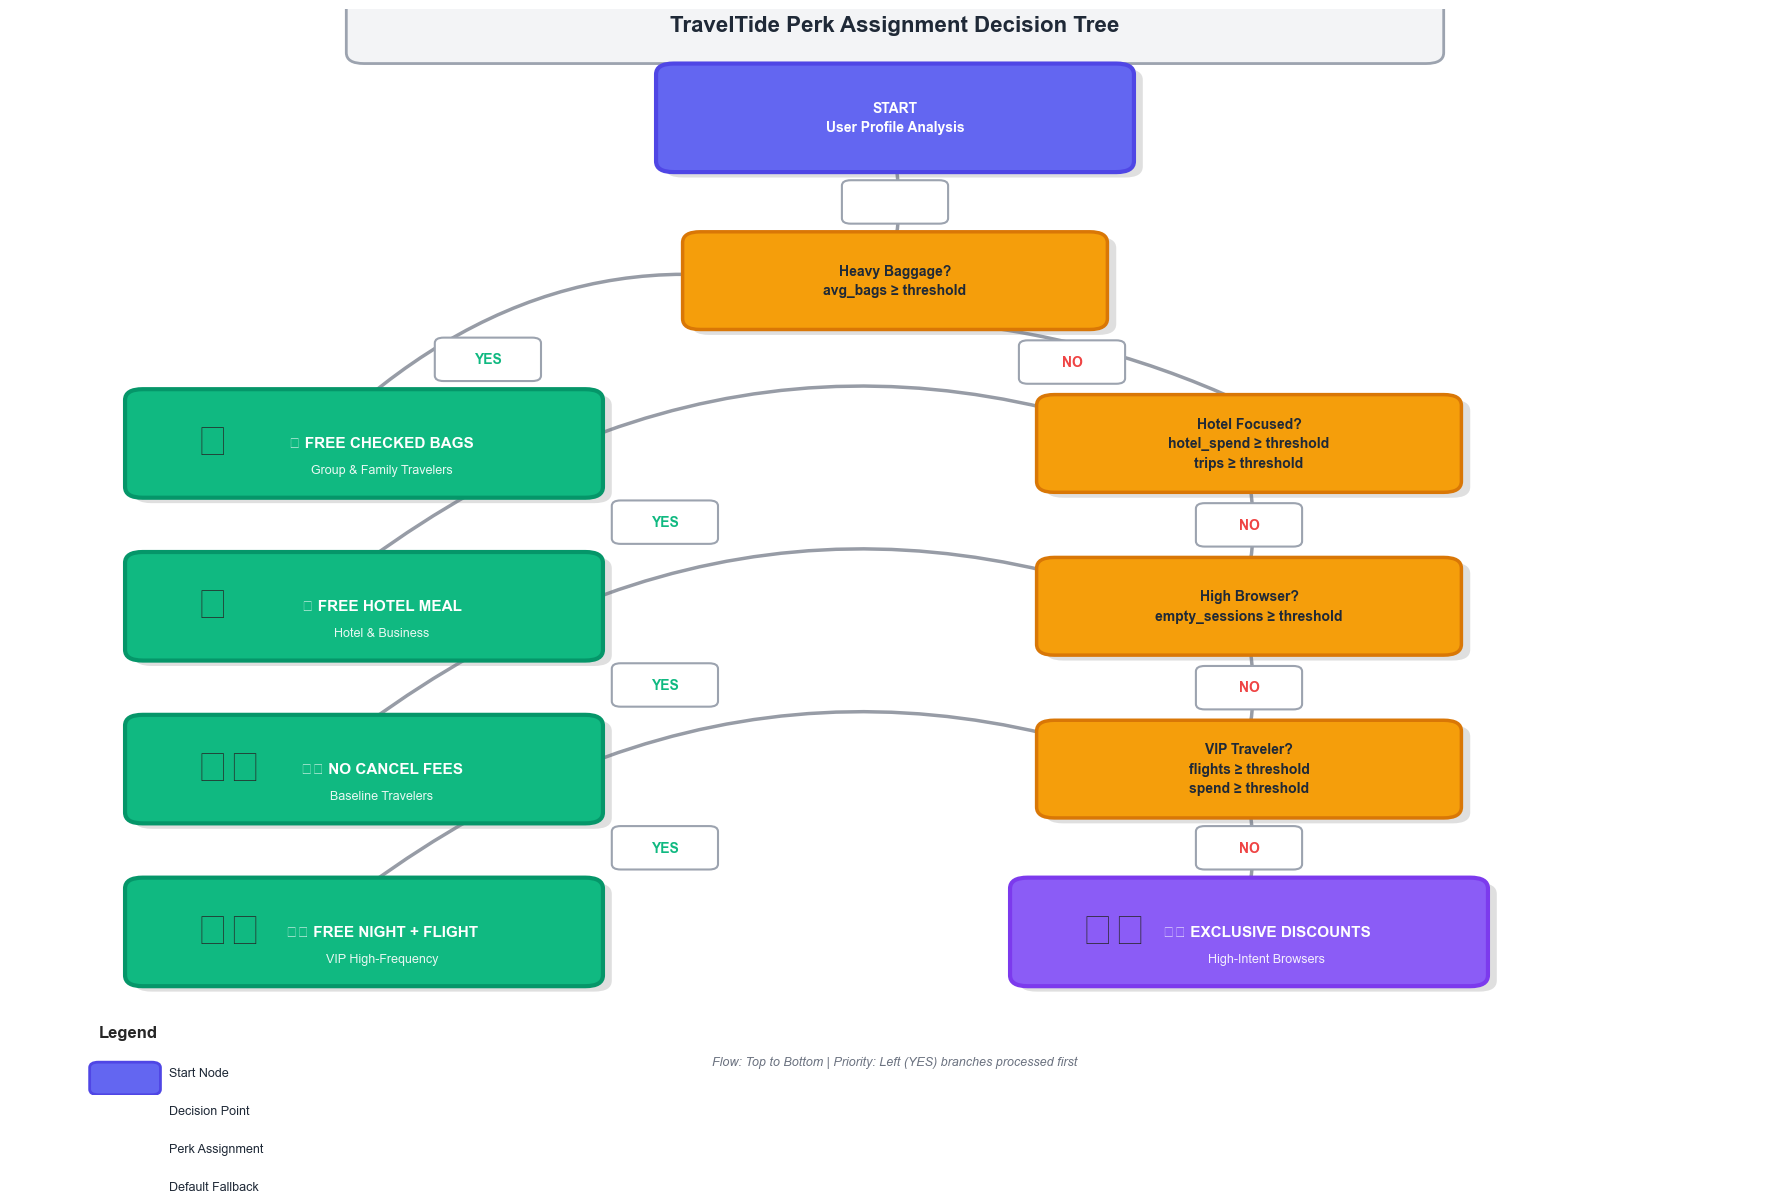

In [33]:
#Create output directory
# Generate visualization
fig = draw_modern_decision_tree()
    
# Save with high quality
output_path = os.path.join(non_ml_fig_path, "perk_assignment_decision_tree_modern.png")
fig.savefig(output_path, dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
    
print(f"✅ Modern decision tree saved: {output_path}")
plt.show()

✅ Modern decision tree saved: /Users/sadiqqais/Masterschool/Projekt/Mastery_projekt/Travel_tide/reports/viz/non_ml/perk_assignment_horizontal_decision_tree_modern.png


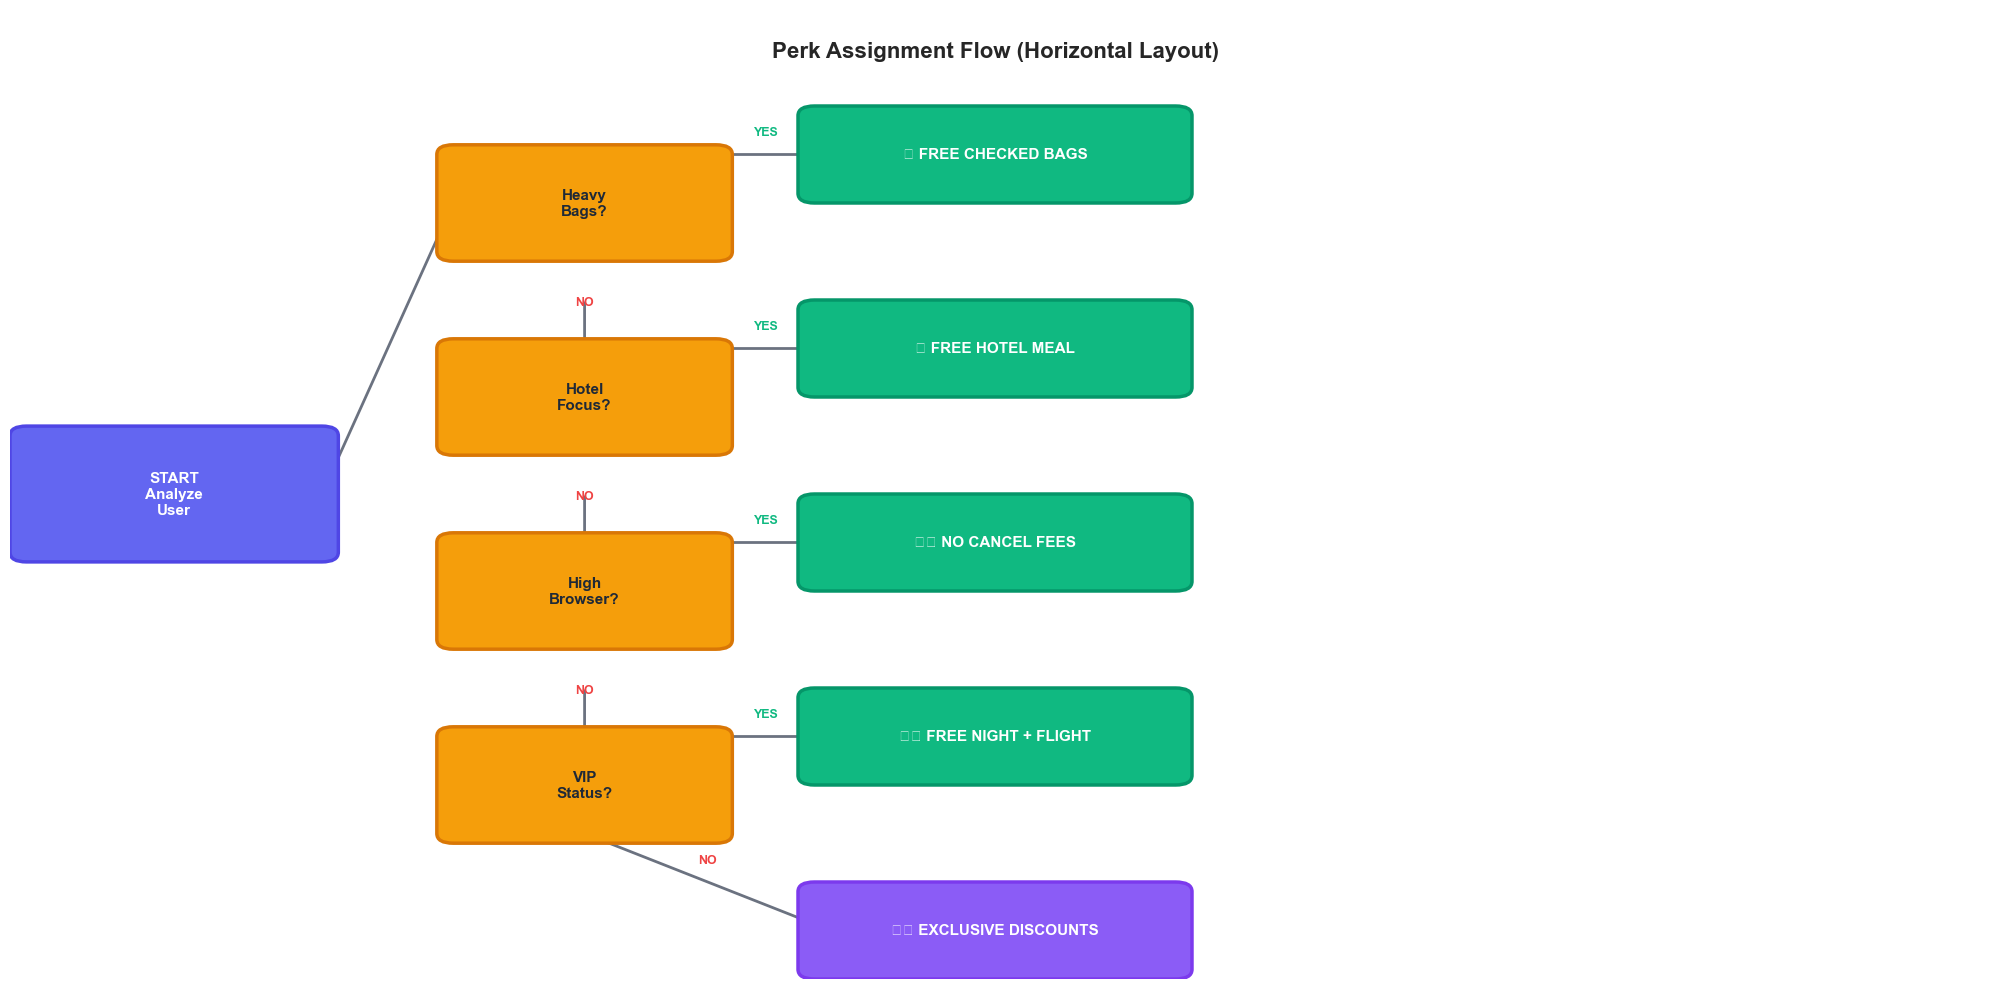

In [34]:
figure = draw_horizontal_decision_tree()
# Save with high quality
output_path = os.path.join(non_ml_fig_path, "perk_assignment_horizontal_decision_tree_modern.png")
figure.savefig(output_path, dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    
print(f"✅ Modern decision tree saved: {output_path}")
plt.show()
